In [14]:
# load data and split into train and test sets
import torch
from load_data import sim_arr
from sklearn.model_selection import train_test_split

# reshape from batch, height, width, channel, to batch, channel, height, width
sim_arr_transformed = sim_arr.reshape(
    sim_arr.shape[0], sim_arr.shape[3], sim_arr.shape[1], sim_arr.shape[2])
train_set, test_set = train_test_split(
    sim_arr_transformed, test_size=0.2, random_state=42)

# convert to tensor
train_set = torch.tensor(train_set, dtype=torch.float32)
test_set = torch.tensor(test_set, dtype=torch.float32)

In [15]:
from AE_torch import Autoencoder
from search_space import search_space
import optuna
import warnings


warnings.filterwarnings("ignore")


def objective(trial):
    #clear clutter from previous runs
    torch.cuda.empty_cache()

    # define search space
    num_layers, poolsize, channels, kernel_sizes, dilations, activations = search_space(trial, input_dim=3, output_dim=3)

    # define model
    model = Autoencoder(num_layers=num_layers,
                        poolsize=poolsize,
                        channels=channels,
                        kernel_sizes=kernel_sizes,
                        dilations=dilations,
                        activations=activations,
                        epochs=10,
                        batch_size=32,
                        learning_rate=1e-3,
                        data=train_set)
    
    # train model with k-fold cross validation
    val_losses = model.cross_val()
    val_loss = sum(val_losses) / len(val_losses)
    print("Validation loss:", val_loss)
    return val_loss

# delete the study
#optuna.delete_study(study_name="autoencoder_torch1", storage="sqlite:///autoencoder.db")

# define study
study = optuna.create_study(direction="minimize",
                            pruner=optuna.pruners.HyperbandPruner(),
                            study_name="autoencoder_torch1",
                            storage="sqlite:///autoencoder.db",
                            load_if_exists=True)

study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", str(best_params))
print("Best value:", study.best_value)


[I 2024-05-08 03:49:39,523] Using an existing study with name 'autoencoder_torch1' instead of creating a new one.


Fold 1/5
Epoch 1/10 Loss: 0.1084
Epoch 2/10 Loss: 0.0714
Epoch 3/10 Loss: 0.0562
Epoch 4/10 Loss: 0.0518
Epoch 5/10 Loss: 0.0539
Epoch 6/10 Loss: 0.0549
Epoch 7/10 Loss: 0.0589
Epoch 8/10 Loss: 0.0894
Epoch 9/10 Loss: 0.0803
Epoch 10/10 Loss: 0.0638
Validation Loss: 0.0571
Fold 2/5
Epoch 1/10 Loss: 0.0584
Epoch 2/10 Loss: 0.0538
Epoch 3/10 Loss: 0.0523
Epoch 4/10 Loss: 0.0534
Epoch 5/10 Loss: 0.0548
Epoch 6/10 Loss: 0.0548
Epoch 7/10 Loss: 0.0557
Epoch 8/10 Loss: 0.0547
Epoch 9/10 Loss: 0.0526
Epoch 10/10 Loss: 0.0548
Validation Loss: 0.0460
Fold 3/5
Epoch 1/10 Loss: 0.0503
Epoch 2/10 Loss: 0.0541
Epoch 3/10 Loss: 0.0567
Epoch 4/10 Loss: 0.0537
Epoch 5/10 Loss: 0.0497
Epoch 6/10 Loss: 0.0501


In [ ]:
# train model with best hyperparameters
num_layers, poolsize, channels, kernel_sizes, dilations, activations = search_space(
    study.best_trial, input_dim=3, output_dim=3)

model = Autoencoder(num_layers=num_layers,
                    poolsize=poolsize,
                    channels=channels,
                    kernel_sizes=kernel_sizes,
                    dilations=dilations,
                    activations=activations,
                    epochs=10,
                    batch_size=32, 
                    learning_rate=1e-3,
                    data=train_set)

model.cross_val()


Fold 1/5
Epoch 1/10 Loss: 0.1003
Epoch 2/10 Loss: 0.0853
Epoch 3/10 Loss: 0.0845
Epoch 4/10 Loss: 0.1020
Epoch 5/10 Loss: 0.0857
Epoch 6/10 Loss: 0.0787
Epoch 7/10 Loss: 0.0779
Epoch 8/10 Loss: 0.0738
Epoch 9/10 Loss: 0.0744
Epoch 10/10 Loss: 0.0724
Validation Loss: 0.0554
Fold 2/5
Epoch 1/10 Loss: 0.0696
Epoch 2/10 Loss: 0.0738
Epoch 3/10 Loss: 0.0676
Epoch 4/10 Loss: 0.0633
Epoch 5/10 Loss: 0.0631
Epoch 6/10 Loss: 0.0607
Epoch 7/10 Loss: 0.0585
Epoch 8/10 Loss: 0.0563
Epoch 9/10 Loss: 0.0550
Epoch 10/10 Loss: 0.0528
Validation Loss: 0.0857
Fold 3/5
Epoch 1/10 Loss: 0.0512
Epoch 2/10 Loss: 0.0508
Epoch 3/10 Loss: 0.0471
Epoch 4/10 Loss: 0.0467
Epoch 5/10 Loss: 0.0453
Epoch 6/10 Loss: 0.0449
Epoch 7/10 Loss: 0.0446
Epoch 8/10 Loss: 0.0430
Epoch 9/10 Loss: 0.0437
Epoch 10/10 Loss: 0.0428
Validation Loss: 0.0291
Fold 4/5
Epoch 1/10 Loss: 0.0423
Epoch 2/10 Loss: 0.0410
Epoch 3/10 Loss: 0.0423
Epoch 4/10 Loss: 0.0409
Epoch 5/10 Loss: 0.0397
Epoch 6/10 Loss: 0.0399
Epoch 7/10 Loss: 0.0406
E

[0.05535724566654298,
 0.08573057852623621,
 0.029071885516627448,
 0.03153858140203908,
 0.026426488841475297]

In [ ]:
# summarize the model
print(model)

Autoencoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): Conv2dSame(3, 10, kernel_size=(21, 21), stride=(1, 1))
      (1): Softplus(beta=1.0, threshold=20.0)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Conv2dSame(10, 11, kernel_size=(8, 8), stride=(1, 1), dilation=(3, 3))
      (4): Softplus(beta=1.0, threshold=20.0)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (6): Conv2dSame(11, 10, kernel_size=(3, 3), stride=(1, 1), dilation=(3, 3))
      (7): Tanh()
      (8): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=True)
      (9): Conv2dSame(10, 8, kernel_size=(20, 20), stride=(1, 1))
      (10): SELU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (12): Conv2dSame(8, 3, kernel_size=(17, 17), stride=(1, 1), dilation=(2, 2))
      (13): SiLU()
      (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

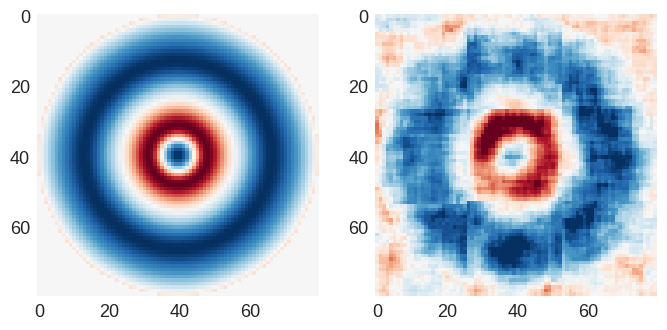

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

i = np.random.randint(0, len(test_set))
in_sim = test_set[i: i + 1]
in_sim = in_sim.to('cuda:0')
out_sim = model(in_sim)
in_sim = in_sim.detach().to('cpu').numpy()
in_sim = in_sim.reshape(in_sim.shape[0], in_sim.shape[2], in_sim.shape[3], in_sim.shape[1])
out_sim = out_sim.detach().to('cpu').numpy()
out_sim = out_sim.reshape(out_sim.shape[0], out_sim.shape[2], out_sim.shape[3], out_sim.shape[1])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(in_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")
ax[1].imshow(out_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")